Repeating the crit chart from EU

In [152]:
# Crit chart
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Times New Roman")

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
cm = 1/2.54 * 1.5


In [153]:

data_adp = "ADP_expanded.xlsx"

df_adp = pd.read_excel(data_adp, engine="openpyxl", sheet_name="CritMats")
df_adp = df_adp[['Symbol', 'Supply Risk', 'EI', 'SR/Prod', 'SR/Prod, norm']]

df_mats_cats = pd.read_excel(
    data_adp, engine="openpyxl", sheet_name="ADP-Elements")
df_mats_cats.set_index("Symbol", inplace=True)

df_adp["Crit"] = "Non Critical"
df_adp["Material Group"] = np.nan
df_adp["ADP-EI"] = np.nan
df_adp["ADP-SR"] = np.nan

# here only information on ADP-EI
df_adp_ei = pd.read_excel(data_adp, engine="openpyxl",
                          sheet_name="ADP-Elements")
df_adp_ei = df_adp_ei[["Symbol", "ADP-EI", "ADP-SR"]]
df_adp_ei.set_index("Symbol", inplace=True)

for idx, row in df_adp.iterrows():
    try:
        df_adp.at[idx, "Material Group"] = df_mats_cats.at[row["Symbol"], "Category"]
    except:
        df_adp.at[idx, "Material Group"] = np.nan
    if df_adp.at[idx, "Material Group"] == "Copper":
        df_adp.at[idx, "Material Group"] = "Other"
    if row["Supply Risk"] >= 1 and row["EI"] >= 2.8:
        df_adp.at[idx, "Crit"] = "Critical"

    if df_adp.at[idx, "Symbol"] in df_adp_ei.index:
        symbol = (df_adp.at[idx, "Symbol"])
        df_adp.at[idx, "ADP-EI"] = df_adp_ei.at[symbol, "ADP-EI"]

    if df_adp.at[idx, "Symbol"] in df_adp_ei.index:
        symbol = (df_adp.at[idx, "Symbol"])
        df_adp.at[idx, "ADP-SR"] = df_adp_ei.at[symbol, "ADP-SR"]
df_adp_vals = df_adp
df_adp_vals = df_adp_vals[df_adp_vals["Material Group"].notna()]
df_adp_vals.to_csv("indicators_values.csv")
df_adp.head()


,Symbol,Supply Risk,EI,SR/Prod,"SR/Prod, norm",Crit,Material Group,ADP-EI,ADP-SR
0,Aggregates,0.2,2.7,NaN,0.000000e+00,Non Critical,NaN,NaN,NaN
1,Al,0.6,5.4,1.451163e-08,1.238326e+04,Non Critical,Base Metals,9.642857e-08,1.500000e-07
2,Sb,2.0,4.8,1.330709e-05,1.135538e+07,Critical,Base Metals,3.428571e+00,2.000000e+01
3,As,1.2,2.6,NaN,0.000000e+00,Non Critical,Other,4.457143e-03,2.880000e-02
4,Ba,1.3,3.3,1.628736e-07,1.389854e+05,Critical,Other,3.300000e-05,1.820000e-04


Include Metal Depletion, Exergy and Mineral Resources

In [154]:
indicators = ["ADP", "CEX", "E99-Min", "ReciPE MDP"]
material_flows = pd.read_excel(data_adp, engine="openpyxl", sheet_name="Flows")
material_flows.set_index("Flow", inplace=True)

for indicator in indicators:
    df_adp_new = pd.read_excel(
        data_adp, engine="openpyxl", sheet_name=indicator)
    df_adp_new["Symbol"] = np.nan
    for idx, row in df_adp_new.iterrows():
        if row["Flow"] in list(material_flows.index):
            df_adp_new.at[idx, "Symbol"] = material_flows.at[row["Flow"],
                                                             "SymbolCorrespondence"]

    df_adp_small = df_adp_new[["Symbol", "Factor"]]
    df_adp_small["Symbol"] = [str(x) for x in df_adp_small["Symbol"]]
    df_adp_small = df_adp_small.groupby('Symbol')['Factor'].agg("mean")
    df_adp_small

    df_adp[indicator] = np.nan
    for idx, row in df_adp.iterrows():
        if row["Symbol"] in list(df_adp_small.keys()):
            df_adp.at[idx, indicator] = df_adp_small[row["Symbol"]]

df_adp.head()
df_adp = df_adp[['Symbol', 'Supply Risk', 'EI', 'SR/Prod, norm', 'Crit',
                 'Material Group', 'ADP-EI', 'ADP-SR', 'ADP', 'CEX', 'E99-Min',
                 'ReciPE MDP']]
rename = {'Supply Risk': "SR",
          'SR/Prod, norm': "GPSR",
          'CEX': "CExD",
          'ReciPE MDP': "MDP"}

df_adp.rename(mapper=rename, inplace=True, axis=1)
for col in df_adp.columns:
    try:
        df_adp[col] = df_adp[col].str.replace(
            'Iron and Ferro-Alloys', 'Ferrous')
    except:
        pass
df_adp


,Symbol,SR,EI,GPSR,Crit,Material Group,ADP-EI,ADP-SR,ADP,CExD,E99-Min,MDP
0,Aggregates,0.2,2.7,0.000000e+00,Non Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Al,0.6,5.4,1.238326e+04,Non Critical,Base Metals,9.642857e-08,1.500000e-07,2.500000e-08,5.730,0.080135,0.090118
2,Sb,2.0,4.8,1.135538e+07,Critical,Base Metals,3.428571e+00,2.000000e+01,1.000000e+00,NaN,NaN,NaN
3,As,1.2,2.6,0.000000e+00,Non Critical,Other,4.457143e-03,2.880000e-02,NaN,NaN,NaN,NaN
4,Ba,1.3,3.3,1.389854e+05,Critical,Other,3.300000e-05,1.820000e-04,1.400000e-05,4.200,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
78,Tg,1.6,8.1,1.866184e+07,Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,Va,1.7,4.4,2.352911e+07,Critical,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,Y,4.2,3.5,2.560000e+05,Critical,REE,2.750000e-05,4.620000e-04,1.100000e-05,NaN,NaN,NaN
81,Zn,0.3,5.4,2.104889e+04,Non Critical,Base Metals,1.080000e-02,8.400000e-03,2.800000e-03,5.615,0.137710,2.254746


C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_3608\299973922.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[1].set_xlim(0,)
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_3608\299973922.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


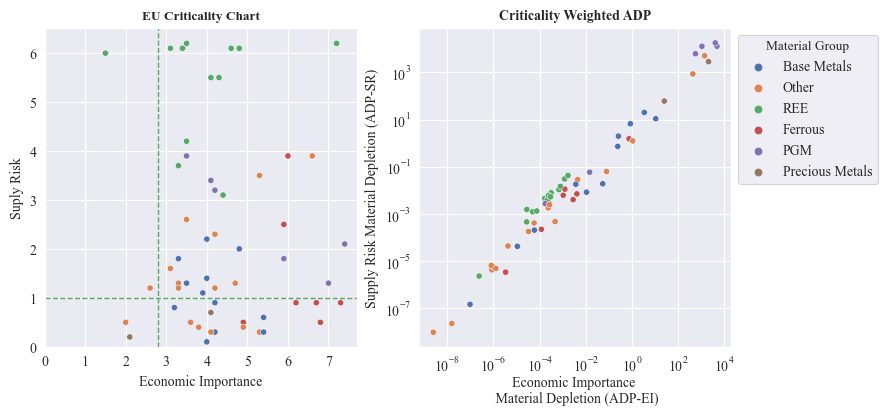

In [155]:
FONT_SMALL = 10
fig, axs = plt.subplots(1, 2, figsize=(15*cm, 7*cm))
axs[0].set_title("EU Criticality Chart", fontweight='bold')
sns.scatterplot(data=df_adp, y='SR', x="EI",
                hue="Material Group", ax=axs[0], s=20)
axs[0].axhline(y=1, color="g", linestyle="--",
               linewidth=1, label="SR Threshold")
axs[0].axvline(x=2.8, color="g", linestyle="--",
               linewidth=1, label="EI Threshold")
axs[0].set_ylim(0,)
axs[0].set_xlim(0,)
axs[0].get_legend().remove()
axs[0].set_xlabel("Economic Importance", fontsize=FONT_SMALL)
axs[0].set_ylabel("Suply Risk", fontsize=FONT_SMALL)


axs[1].set_title("Criticality Weighted ADP",
                 fontweight='bold', fontsize=FONT_SMALL)
sns.scatterplot(data=df_adp, y='ADP-SR', x="ADP-EI",
                hue="Material Group", ax=axs[1], s=20)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlim(0,)
axs[1].legend(fontsize=FONT_SMALL, title="Material Group",
              bbox_to_anchor=(1, 1))
axs[1].set_xlabel("Economic Importance \n Material Depletion (ADP-EI)",
                  fontsize=FONT_SMALL, labelpad=1)
axs[1].set_ylabel("Supply Risk Material Depletion (ADP-SR)",
                  fontsize=FONT_SMALL)  # , labelpad=1)

for ax in axs:
    ax.tick_params(axis='both', which='major', pad=1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FONT_SMALL)

fig.savefig("Citicality.svg", bbox_inches='tight', dpi=600)
fig.show()


C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_3608\1400460820.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


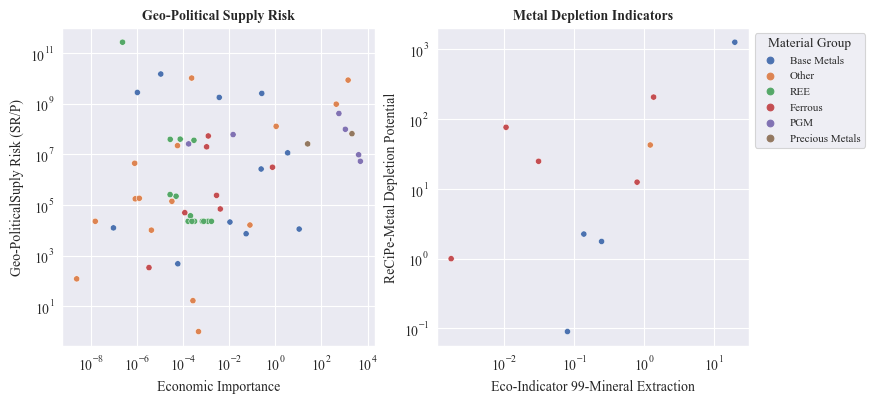

In [156]:
FONT_SMALL = 10
fig, axs = plt.subplots(1, 2, figsize=(15*cm, 7*cm))
axs[0].set_title("Geo-Political Supply Risk",
                 fontweight='bold', fontsize=FONT_SMALL)
sns.scatterplot(data=df_adp, y='GPSR', x="ADP-EI",
                hue="Material Group", ax=axs[0], s=20)
axs[0].get_legend().remove()
axs[0].set_xlabel("Economic Importance", fontsize=FONT_SMALL)
axs[0].set_ylabel("Geo-PoliticalSuply Risk (SR/P)", fontsize=FONT_SMALL)
axs[0].set_yscale('log')
axs[0].set_xscale('log')


# E99-Min	MDP
axs[1].set_title("Metal Depletion Indicators",
                 fontweight='bold', fontsize=FONT_SMALL)
sns.scatterplot(data=df_adp, y='MDP', x="E99-Min",
                hue="Material Group", ax=axs[1], s=20)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_xlim(0,)
axs[1].legend(fontsize=8, title="Material Group", bbox_to_anchor=(1, 1))
axs[1].set_xlabel("Eco-Indicator 99-Mineral Extraction", fontsize=FONT_SMALL)
axs[1].set_ylabel("ReCiPe-Metal Depletion Potential",
                  fontsize=FONT_SMALL)  # , labelpad=1)

for ax in axs:
    ax.tick_params(axis='both', which='major', pad=1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FONT_SMALL)


fig.savefig("GPSR_MDP.svg", bbox_inches='tight', dpi=600)
fig.show()
# df_adp


C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_3608\3252193028.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


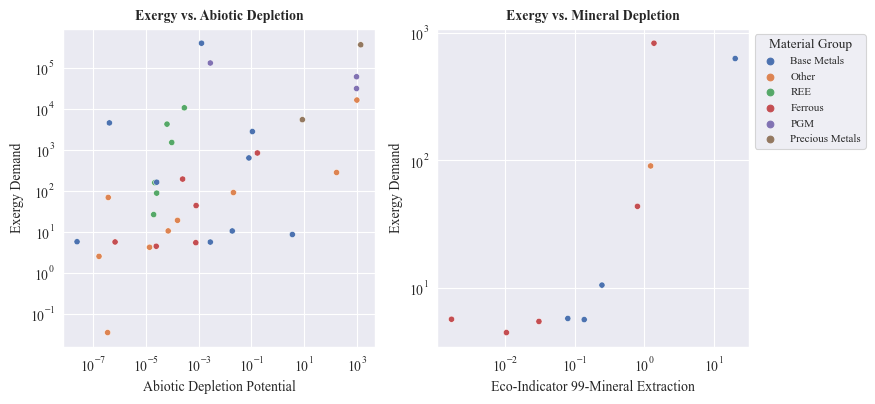

In [157]:
FONT_SMALL = 10
fig, axs = plt.subplots(1, 2, figsize=(15*cm, 7*cm))
axs[0].set_title("Exergy vs. Abiotic Depletion",
                 fontweight='bold', fontsize=FONT_SMALL)
sns.scatterplot(data=df_adp, y='CExD', x="ADP",
                hue="Material Group", ax=axs[0], s=20)
axs[0].get_legend().remove()
axs[0].set_xlabel("Abiotic Depletion Potential", fontsize=FONT_SMALL)
axs[0].set_ylabel("Exergy Demand", fontsize=FONT_SMALL)
axs[0].set_yscale('log')
axs[0].set_xscale('log')


# ADP	CExD	E99-Min	MDP
axs[1].set_title("Exergy vs. Mineral Depletion",
                 fontweight='bold', fontsize=FONT_SMALL)
sns.scatterplot(data=df_adp, y='CExD', x="E99-Min",
                hue="Material Group", ax=axs[1], s=20)
axs[1].set_yscale('log')
axs[1].set_xscale('log')

axs[1].legend(fontsize=8, title="Material Group", bbox_to_anchor=(1, 1))
axs[1].set_xlabel("Eco-Indicator 99-Mineral Extraction", fontsize=FONT_SMALL)
axs[1].set_ylabel("Exergy Demand", fontsize=FONT_SMALL)

for ax in axs:
    ax.tick_params(axis='both', which='major', pad=1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FONT_SMALL)


fig.savefig("CEXD.svg", bbox_inches='tight', dpi=600)
fig.show()
# df_adp


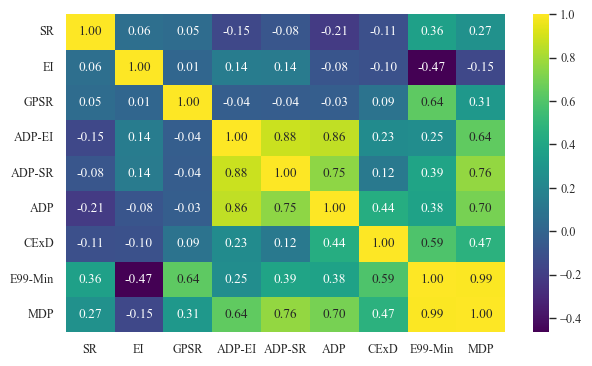

In [158]:
fig, ax = plt.subplots(figsize=(12*cm, 7*cm))
df_heat_map = df_adp.drop(["Crit", "Material Group"], axis=1)
df_heat_map.set_index("Symbol", inplace=True)
df_corr = df_heat_map.corr()
sns.heatmap(data=df_corr, cmap="viridis", annot=True, fmt=".2f", ax=ax)
fig.savefig("heatmap.svg", bbox_inches='tight', dpi=600)
